In [1]:
import matplotlib.pyplot as plt
import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import gd1_util 
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from gd1_util_MWhaloshape import phi12_to_lb_6d, lb_to_phi12
import SCFbar_util_new
import spiralarms_util

def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)


Populating the interactive namespace from numpy and matplotlib


In [2]:
#coloring stuff

cmap= cm.plasma

def color_from_colormap(val,cmap,cmin,cmax):
    va=[]
    for v in val:
        va.append(cmap((v-cmin)/(cmax-cmin)))
        
    return va

def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None

def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

In [8]:
# Setup the spiral, using 4 arms and 1% of background radial force, pattern speed 24.5 km/s/kpc

spiralpot=spiralarms_util.spiral_arms_potential(N=4,tstream=9.,Rs=5.)

growing spiral


In [5]:
N=100
Rl,phil,zl,_,_,_,dtl =spiralarms_util.sample_streamdf_noprog_spiral(N,spiralpot=spiralpot,stream='GD1',trailing=False)
Rt,phit,zt,_,_,_,dtt =spiralarms_util.sample_streamdf_noprog_spiral(N,spiralpot=spiralpot,stream='GD1',trailing=True)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


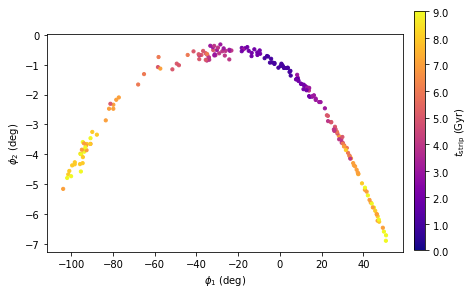

In [7]:
#stripping time bins:
t_age= 9. 
dt_bins=np.linspace(0.,t_age,10)
print (dt_bins)

dtt_p=numpy.digitize(dtt*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
dtl_p=numpy.digitize(dtl*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)

lt,bt,_=np.array(galcencyl_to_lbd(Rt,phit,zt))
ll,bl,_=np.array(galcencyl_to_lbd(Rl,phil,zl))
    
phi12t=lb_to_phi12(lt,bt,degree=True)
phi12l=lb_to_phi12(ll,bl,degree=True)

phi1t=phi12t[:,0]
phi1t[phi1t > 180.]-=360.
phi2t=phi12t[:,1]

phi1l=phi12l[:,0]
phi1l[phi1l > 180.]-=360.
phi2l=phi12l[:,1]

#plot unperturbed stream 
plt.figure()
plt.scatter(phi1l,phi2l,s=10,color=color_from_colormap(dtl_p,cmap,0.,9.))
plt.scatter(phi1t,phi2t,s=10,color=color_from_colormap(dtt_p,cmap,0.,9.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='r')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.ylabel(r'$\phi_{2}$ (deg)')
add_colorbar(0.,9.,r'$t_{\rm{strip}}$ (Gyr)')
plt.show()

In [3]:
def process_sample(N,dir_trail):
    #dir_trail contains all the sample files from the trailing arm
    
    dir_lead = dir_trail.replace('trailing','leading')
    allfname_trail= glob.glob(dir_trail + '*.dat')
    allfname_lead= glob.glob(dir_lead + '*.dat')
    R_t=[]
    phi_t=[]
    z_t=[]
    vR_t=[]
    vT_t=[]
    vz_t=[]
    t_t=[]

    R_l=[]
    phi_l=[]
    z_l=[]
    vR_l=[]
    vT_l=[]
    vz_l=[]
    t_l=[]
     
    for i in range(N):
    #for i in range(10):
        try :
            R_t.append(numpy.loadtxt(allfname_trail[i])[:,0])
            phi_t.append(numpy.loadtxt(allfname_trail[i])[:,1])
            z_t.append(numpy.loadtxt(allfname_trail[i])[:,2])
            vR_t.append(numpy.loadtxt(allfname_trail[i])[:,3])
            vT_t.append(numpy.loadtxt(allfname_trail[i])[:,4])
            vz_t.append(numpy.loadtxt(allfname_trail[i])[:,5])
            t_t.append(numpy.loadtxt(allfname_trail[i])[:,6])
            
        except ValueError : 
            print (allfname_trail[i])
        
    for ii in range(N):
    #for ii in range(10): 
        try :
            R_l.append(numpy.loadtxt(allfname_lead[ii])[:,0])
            phi_l.append(numpy.loadtxt(allfname_lead[ii])[:,1])
            z_l.append(numpy.loadtxt(allfname_lead[ii])[:,2])
            vR_l.append(numpy.loadtxt(allfname_lead[ii])[:,3])
            vT_l.append(numpy.loadtxt(allfname_lead[ii])[:,4])
            vz_l.append(numpy.loadtxt(allfname_lead[ii])[:,5])
            t_l.append(numpy.loadtxt(allfname_lead[ii])[:,6])
            
        except ValueError : 
            print (allfname_lead[ii])
        
    Rall_t = np.array([item for sublist in R_t for item in sublist])
    phiall_t = np.array([item for sublist in phi_t for item in sublist])
    zall_t = np.array([item for sublist in z_t for item in sublist])
    vRall_t = np.array([item for sublist in vR_t for item in sublist])
    vTall_t = np.array([item for sublist in vT_t for item in sublist])
    vzall_t = np.array([item for sublist in vz_t for item in sublist])
    tall_t = np.array([item for sublist in t_t for item in sublist])

    Rall_l = np.array([item for sublist in R_l for item in sublist])
    phiall_l = np.array([item for sublist in phi_l for item in sublist])
    zall_l = np.array([item for sublist in z_l for item in sublist])
    vRall_l = np.array([item for sublist in vR_l for item in sublist])
    vTall_l = np.array([item for sublist in vT_l for item in sublist])
    vzall_l = np.array([item for sublist in vz_l for item in sublist])
    tall_l = np.array([item for sublist in t_l for item in sublist])
    
    #x_l,y_l,z_l=bovy_coords.cyl_to_rect(Rall_l,phiall_l,zall_l)
    
    l_t,b_t,d_t=np.array(galcencyl_to_lbd(Rall_t,phiall_t,zall_t))
    l_l,b_l,d_l=np.array(galcencyl_to_lbd(Rall_l,phiall_l,zall_l))
    
    #radec_t=bovy_coords.lb_to_radec(l_t,b_t,degree=True) 
    #radec_l=bovy_coords.lb_to_radec(l_l,b_l,degree=True)
    
     
   
    phi12_l=lb_to_phi12(l_l,b_l,degree=True)
    phi12_t=lb_to_phi12(l_t,b_t,degree=True)

    phi1_l=phi12_l[:,0]
    phi1_l[phi1_l > 180.]-=360.
    phi2_l=phi12_l[:,1]
    
    phi1_t=phi12_t[:,0]
    phi1_t[phi1_t > 180.]-=360.
    phi2_t=phi12_t[:,1]
    
    return (phi1_l, phi2_l, phi1_t, phi2_t)

def include_both_arms(phi1_l,phi2_l,phi1_t,phi2_t):
    min_phi2_l=min(phi2_l)
    max_phi2_l=max(phi2_l)

    phi1_t_select=[]
    phi2_t_select=[]

    for jj in range(len(phi2_t)):
        if min_phi2_l <= phi2_t[jj] <= max_phi2_l :
            phi1_t_select.append(phi1_t[jj])
            phi2_t_select.append(phi2_t[jj])

    print (len(phi1_t), len(phi1_t_select))

       
    phi1_all = np.concatenate((phi1_l,phi1_t_select))
    
    return phi1_all

def compute_ndenphi1(phi1,maxphi1=15.,minphi1=-60.,bw=2.,polydeg=3):
    N=len(phi1)
    print (N)
    
    nbins= (maxphi1 - minphi1)/bw
    print ("no of xi bins = %i"%nbins)

    phi1bin_edge=[(minphi1-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midphi1=[0.5*(phi1bin_edge[i] + phi1bin_edge[i+1]) for i in range(int(nbins)+1)]
    
    Ndn=np.histogram(phi1,phi1bin_edge)[0]
    print (np.sum(Ndn))
    Ndn_err=numpy.sqrt(Ndn)
       
    pp= Polynomial.fit(midphi1,Ndn,deg=polydeg,w=1/(Ndn_err))
    nden=Ndn/pp(np.array(midphi1))
    nden_err=np.sqrt(Ndn)/pp(np.array(midphi1))
        
    
    return (midphi1,Ndn,Ndn_err,nden,nden_err,pp(np.array(midphi1)))

def compute_Pk(filename, scaling = 'spectrum'):
    data= numpy.loadtxt(filename)
    p1=data[:,0][4:]
    tdata=data[:,1][4:]
    data_err=data[:,2][4:]
    
    #print (p1)
    
    
    px,py= signal.csd(tdata,tdata,fs=1./(p1[1]-p1[0]),scaling=scaling,nperseg=len(p1))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(p1[-1]-p1[0]))
    
            
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(p1))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(p1[1]-p1[0]),scaling=scaling,
                                nperseg=len(p1))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(p1[-1]-p1[0]))
    
    #return 180./px/numpy.pi, py, py_err #if apars
    return px, py, py_err


# N=4 spiral

50500 50497


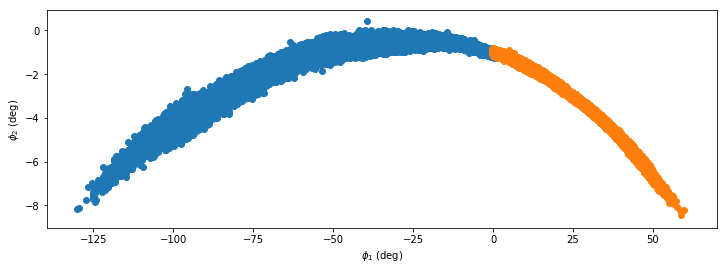

In [10]:
phi1_l,phi2_l, phi1_t, phi2_t=process_sample(101,'GD1sampled_spiral/streamdf_FR1_N4_24p5_5Gyr/trailing/')
phi1_all = include_both_arms(phi1_l,phi2_l,phi1_t,phi2_t)

plt.figure(figsize=(12,4))
plt.scatter(phi1_l,phi2_l)
plt.scatter(phi1_t,phi2_t)
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.ylabel(r'$\phi_{2}$ (deg)')
plt.show()


100997
no of xi bins = 37
45916


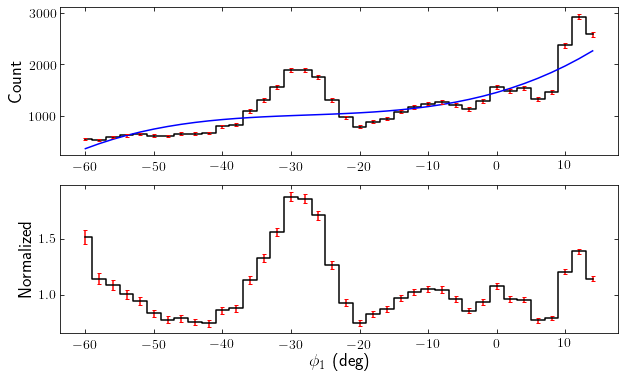

In [14]:
midphi1,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenphi1(phi1_all,maxphi1=15.,minphi1=-60.)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(midphi1,Ndn,ls='steps-mid',c='k')
plt.plot(midphi1,pp,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1,Ndn,Ndn_err,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,1,2)
plt.plot(midphi1,nden,ls='steps-mid',c='k')
plt.errorbar(midphi1,nden,nden_err,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

In [12]:
fo=open('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_FR1_poly3norm.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden)):
    fo.write(str(midphi1[jj]) + "   " + str(nden[jj]) + "   " + str(nden_err[jj]) + "\n")

fo.close()
    

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in true_divide



Text(0,0.5,'$\\sqrt{P_{\\delta\\delta}(k_{\\phi_{1}})}$')

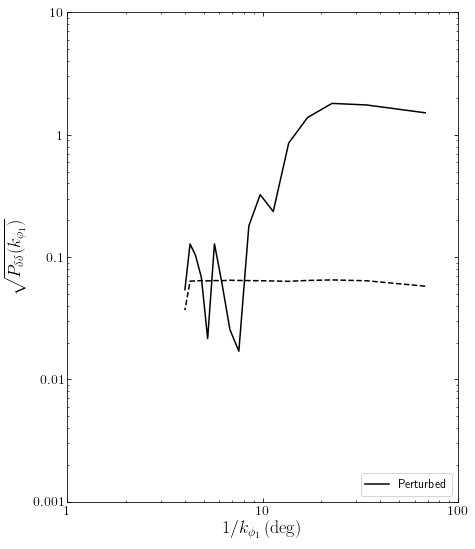

In [15]:
def set_ranges_and_labels_dens():
    
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=18)
    ylim(0.001,10.)
    xlim(1,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None


px,py,py_err = compute_Pk('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_FR1_poly3norm.dat')


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)

loglog(px,py,color='k',zorder=1,label='Perturbed')
loglog(px,py_err,color='k',ls='--',zorder=1)
legend(loc='lower right')

set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)
#savefig('plots/GD-1_power_gaia.pdf')



# N=4 spiral Rs = 5 kpc

50500 50500


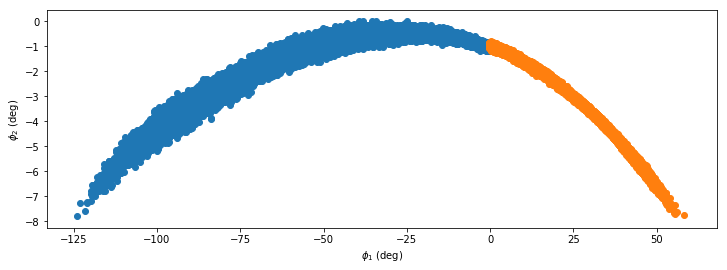

In [4]:
phi1_l,phi2_l, phi1_t, phi2_t=process_sample(101,'GD1sampled_spiral/streamdf_FR1_N4_24p5_5Gyr_5kpcScaleLength/trailing/')
phi1_all = include_both_arms(phi1_l,phi2_l,phi1_t,phi2_t)

plt.figure(figsize=(12,4))
plt.scatter(phi1_l,phi2_l)
plt.scatter(phi1_t,phi2_t)
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.ylabel(r'$\phi_{2}$ (deg)')
plt.show()


101000
no of xi bins = 37
44485


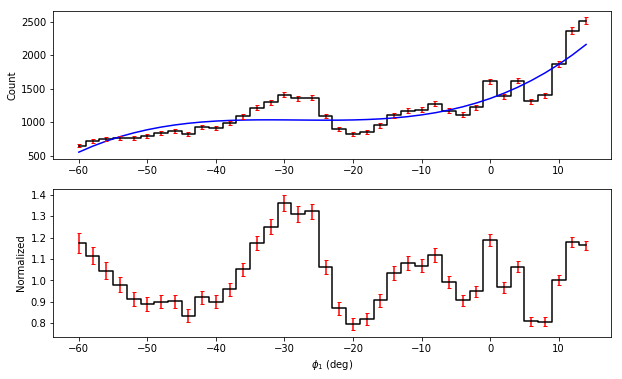

In [5]:
midphi1,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenphi1(phi1_all,maxphi1=15.,minphi1=-60.)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(midphi1,Ndn,ls='steps-mid',c='k')
plt.plot(midphi1,pp,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1,Ndn,Ndn_err,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,1,2)
plt.plot(midphi1,nden,ls='steps-mid',c='k')
plt.errorbar(midphi1,nden,nden_err,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

In [6]:
fo=open('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_Rs5kpc_FR1_poly3norm.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden)):
    fo.write(str(midphi1[jj]) + "   " + str(nden[jj]) + "   " + str(nden_err[jj]) + "\n")

fo.close()
    

# N=4 spiral Rs = 3 kpc

50500 50497


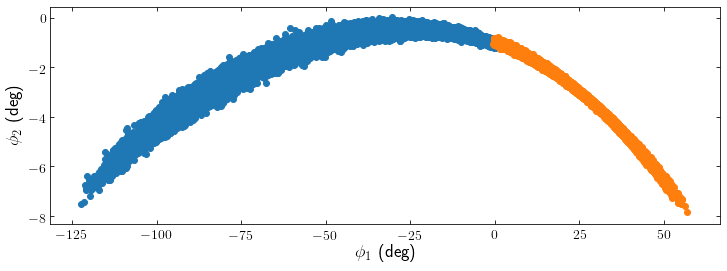

In [12]:
phi1_l,phi2_l, phi1_t, phi2_t=process_sample(101,'GD1sampled_spiral/streamdf_FR1_N4_24p5_5Gyr_3kpcScaleLength/trailing/')
phi1_all = include_both_arms(phi1_l,phi2_l,phi1_t,phi2_t)

plt.figure(figsize=(12,4))
plt.scatter(phi1_l,phi2_l)
plt.scatter(phi1_t,phi2_t)
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.ylabel(r'$\phi_{2}$ (deg)')
plt.show()


100997
no of xi bins = 37
42754


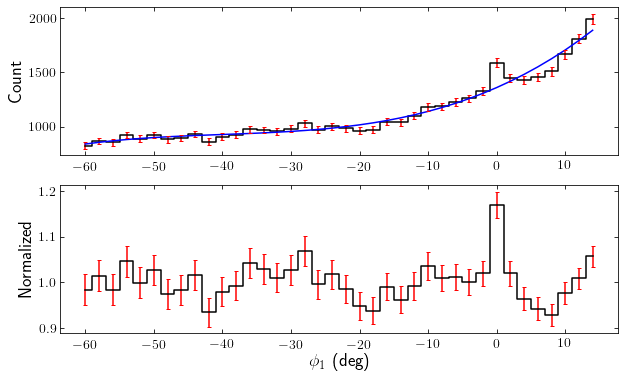

In [13]:
midphi1,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenphi1(phi1_all,maxphi1=15.,minphi1=-60.)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(midphi1,Ndn,ls='steps-mid',c='k')
plt.plot(midphi1,pp,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1,Ndn,Ndn_err,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,1,2)
plt.plot(midphi1,nden,ls='steps-mid',c='k')
plt.errorbar(midphi1,nden,nden_err,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

In [14]:
fo=open('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_Rs3kpc_FR1_poly3norm.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden)):
    fo.write(str(midphi1[jj]) + "   " + str(nden[jj]) + "   " + str(nden_err[jj]) + "\n")

fo.close()
    

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in true_divide



Text(0,0.5,'$\\sqrt{P_{\\delta\\delta}(k_{\\phi_{1}})}$')

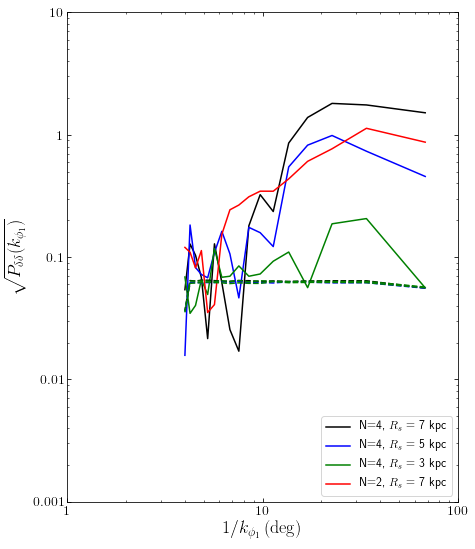

In [15]:
def set_ranges_and_labels_dens():
    
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=18)
    ylim(0.001,10.)
    xlim(1,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None

px,py,py_err = compute_Pk('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_FR1_poly3norm.dat')
px1,py1,py_err1 = compute_Pk('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_Rs5kpc_FR1_poly3norm.dat')
px2,py2,py_err2 = compute_Pk('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_Rs3kpc_FR1_poly3norm.dat')
px3,py3,py_err3 = compute_Pk('GD1_density_botharms_streamdf_N2_spiral_5Gyr_24p5patspeed_FR1_poly3norm.dat')


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)

loglog(px,py,color='k',zorder=1,label=r'N=4, $R_{s}$ = 7 kpc')
loglog(px1,py1,color='b',zorder=1,label=r'N=4, $R_{s}$ = 5 kpc')
loglog(px2,py2,color='g',zorder=1,label=r'N=4, $R_{s}$ = 3 kpc')
loglog(px3,py3,color='r',zorder=1,label=r'N=2, $R_{s}$ = 7 kpc')
loglog(px,py_err,color='k',ls='--',zorder=1)
loglog(px1,py_err1,color='b',ls='--',zorder=1)
loglog(px2,py_err2,color='g',ls='--',zorder=1)
loglog(px3,py_err3,color='g',ls='--',zorder=1)
legend(loc='lower right')

set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)
#savefig('plots/GD-1_power_gaia.pdf')



# N=2 spiral

50500 50237


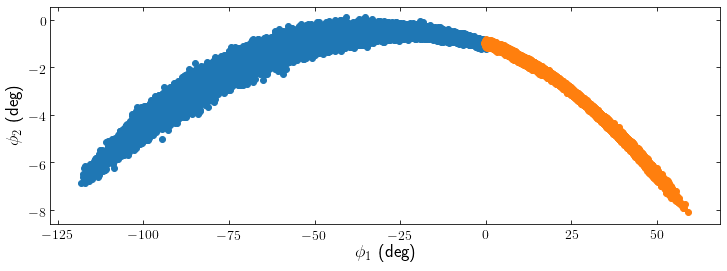

In [29]:
phi1_l,phi2_l, phi1_t, phi2_t=process_sample(101,'GD1sampled_spiral/streamdf_FR1_N2_24p5_5Gyr/trailing/')
phi1_all = include_both_arms(phi1_l,phi2_l,phi1_t,phi2_t)

plt.figure(figsize=(12,4))
plt.scatter(phi1_l,phi2_l)
plt.scatter(phi1_t,phi2_t)
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.ylabel(r'$\phi_{2}$ (deg)')
plt.show()



100737
no of xi bins = 37
43297


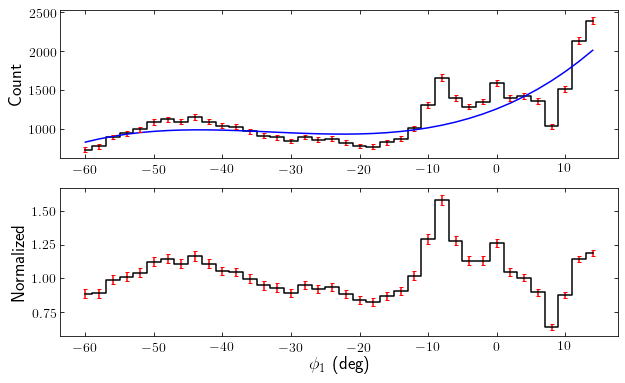

In [30]:
midphi1,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenphi1(phi1_all,maxphi1=15.,minphi1=-60.)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(midphi1,Ndn,ls='steps-mid',c='k')
plt.plot(midphi1,pp,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1,Ndn,Ndn_err,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,1,2)
plt.plot(midphi1,nden,ls='steps-mid',c='k')
plt.errorbar(midphi1,nden,nden_err,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

In [31]:
fo=open('GD1_density_botharms_streamdf_N2_spiral_5Gyr_24p5patspeed_FR1_poly3norm.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden)):
    fo.write(str(midphi1[jj]) + "   " + str(nden[jj]) + "   " + str(nden_err[jj]) + "\n")

fo.close()
    

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in true_divide



Text(0,0.5,'$\\sqrt{P_{\\delta\\delta}(k_{\\phi_{1}})}$')

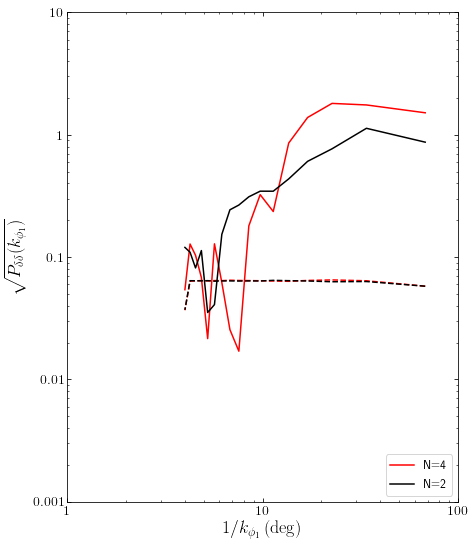

In [32]:
px1,py1,py_err1 = compute_Pk('GD1_density_botharms_streamdf_N2_spiral_5Gyr_24p5patspeed_FR1_poly3norm.dat')


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)

loglog(px,py,color='r',zorder=1,label='N=4')
loglog(px,py_err,color='r',ls='--',zorder=1)

loglog(px1,py1,color='k',zorder=1,label='N=2')
loglog(px1,py_err1,color='k',ls='--',zorder=1)
legend(loc='lower right')

set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)

### GD-1's orbit in the last 2 Gyr, it passes through the disk R~ 15 kpc twice 

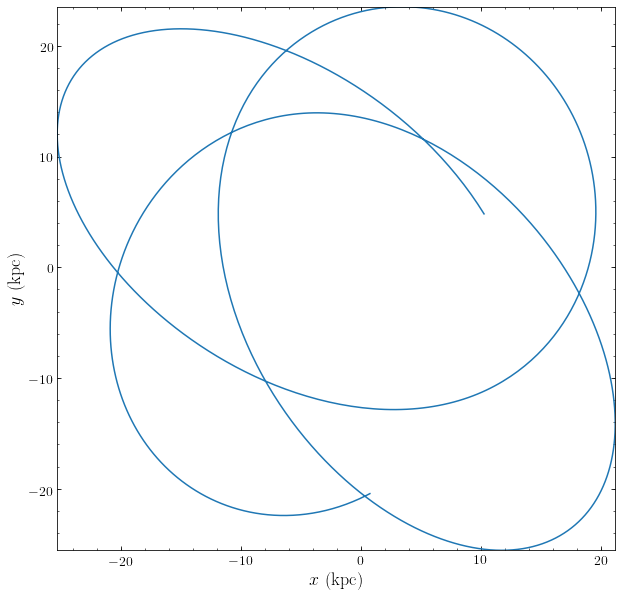

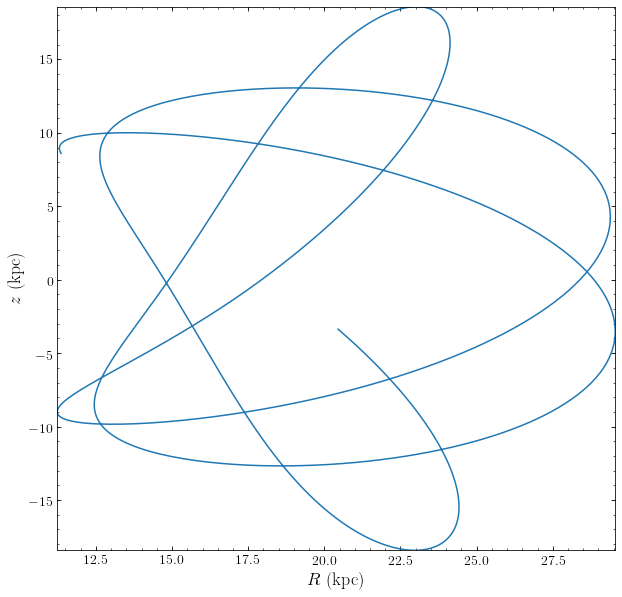

In [23]:
ro=8.
vo=220.
obs=Orbit(phi12_to_lb_6d(0,-0.82,10.1,-8.5,-2.15,-257.),lb=True,solarmotion=[-11.1,24.,7.25],ro=8.,vo=220.)
ts= numpy.linspace(0.,-2./bovy_conversion.time_in_Gyr(vo,ro),1001)

obs.integrate(ts,spiralpot)

figsize(10,10)
obs.plot(d1='x',d2='y')
obs.plot(d1='R',d2='z')

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)



array([[-1.50532191e-07,  2.40567489e-08,  1.70009858e-07, ...,
         1.70009858e-07,  2.40567489e-08, -1.50532191e-07],
       [-1.71392508e-07,  1.97688900e-08,  1.82454160e-07, ...,
         1.82454160e-07,  1.97688900e-08, -1.71392508e-07],
       [-1.94127298e-07,  1.48766703e-08,  1.95692696e-07, ...,
         1.95692696e-07,  1.48766703e-08, -1.94127298e-07],
       ...,
       [-1.94127298e-07,  1.48766703e-08,  1.95692696e-07, ...,
         1.95692696e-07,  1.48766703e-08, -1.94127298e-07],
       [-1.71392508e-07,  1.97688900e-08,  1.82454160e-07, ...,
         1.82454160e-07,  1.97688900e-08, -1.71392508e-07],
       [-1.50532191e-07,  2.40567489e-08,  1.70009858e-07, ...,
         1.70009858e-07,  2.40567489e-08, -1.50532191e-07]])

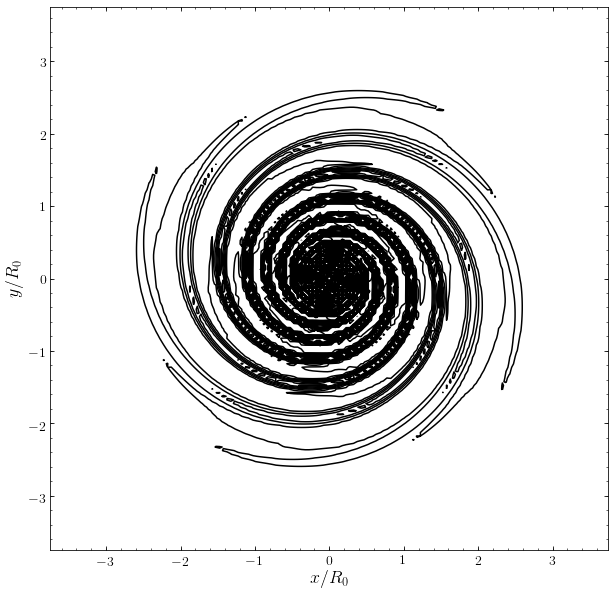

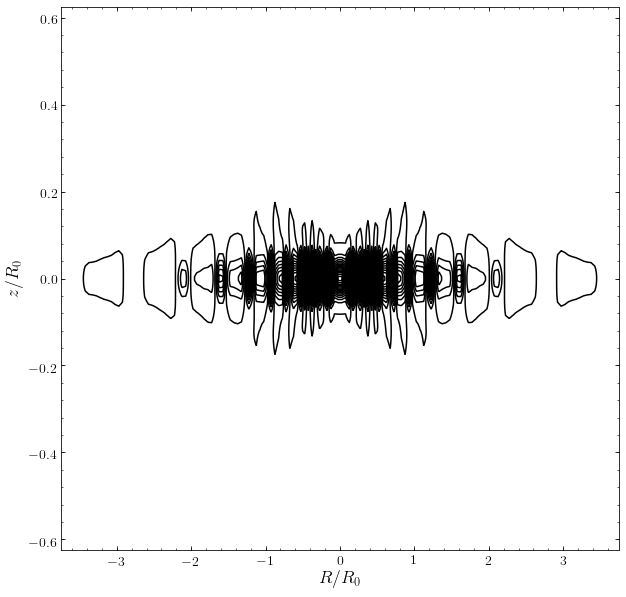

In [9]:
from galpy.potential import MWPotential2014, turn_physical_off, MiyamotoNagaiPotential, plotDensities,evaluateDensities, SpiralArmsPotential

figsize(10,10)
plotDensities(spiralpot[-1],justcontours=True,rmin=-30.*u.kpc,rmax=30.*u.kpc,zmax=30.*u.kpc,zmin=-30.*u.kpc,nrs=150,nzs=150,ncontours=65,xy=True,t=-2.*u.Gyr)
plotDensities(spiralpot[-1],justcontours=True,rmin=-30.*u.kpc,rmax=30.*u.kpc,zmax=5.*u.kpc,zmin=-5.*u.kpc,nrs=150,nzs=150,ncontours=65,xy=False,phi=1.,t=-2.*u.Gyr)

In [39]:
obs.animate(d1=['x','R','R'],d2=['y','t','z'],width=1000)

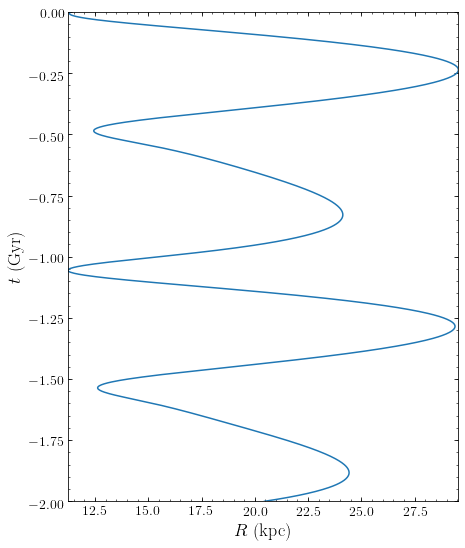

In [40]:
obs.plot(d1='R',d2='t')

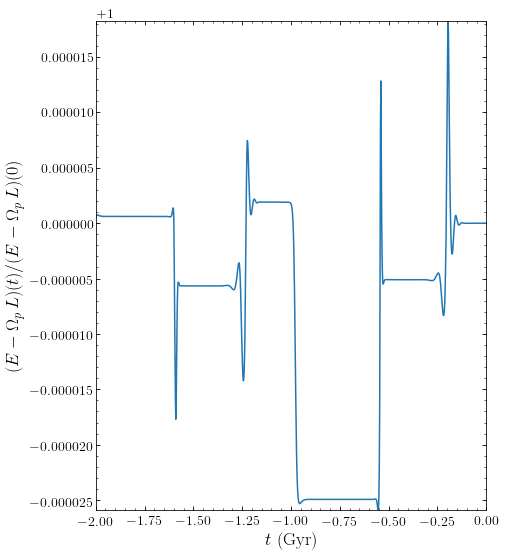

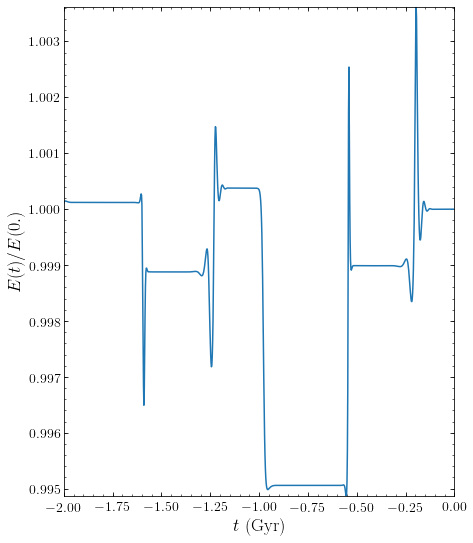

In [33]:
obs.plotJacobi(normed=True)
obs.plotE(normed=True)